## Import Important Packages 


In [1]:
import numpy as np 
import os
import cv2
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import model_from_yaml

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import cv2
import glob
import itertools
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 



## GPU configuration

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Add the Custom loss functions 

In [3]:
from tensorflow.keras import backend as K

def IoU(y_true, y_pred):
        
    ''' 
    The Intersection over Union (IoU) also referred to as the Jaccard index (JI),
    is essentially a method to quantify the percent overlap between the GT mask
    and prediction output. The IoU metric measures the number of pixels common 
    between the target and prediction masks divided by the total number of pixels
    present across both masks.
  
    Input Arguments: 
        y_true: True Labels of the 2D images so called ground truth (GT).
        y_pred: Predicted Labels of the 2D images so called Predicted/ segmented Mask.
        
    Output Arguments: 

        iou: The IoU between y_true and y_pred

    Author: Md. Kamrul Hasan, 
            Erasmus Scholar on Medical Imaging and Application (MAIA)
            E-mail: kamruleeekuet@gmail.com

    '''
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f)-intersection)


def IoU_loss(y_true, y_pred):
    return 1-IoU(y_true, y_pred)


def bce_IoU_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + IoU_loss(y_true, y_pred))


## Model Architecture 

In [4]:
#...................Model............................
def pretrained(nClasses, input_height, input_width):
  img_input = Input(shape=(input_height, input_width, 3)) 

  #...................Feature Generator..............................
  FrG = SeparableConv2D(filters = 64,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding="same")(img_input)
                          
  FrG = BatchNormalization()(FrG)
  
  FrG = SeparableConv2D(filters = 256,
                        kernel_size = (3, 3),
                        activation = 'relu', 
                        kernel_initializer='glorot_uniform', 
                        padding="same")(FrG)
  FrG = BatchNormalization()(FrG)
      
  FrG = SeparableConv2D(filters = 64,
                        kernel_size = (3, 3), 
                        activation = 'relu',
                        kernel_initializer='glorot_uniform',
                        padding="same")(FrG)
  FrG = BatchNormalization()(FrG)
  
  FrG = SeparableConv2D(filters = nClasses,
                        kernel_size = (3, 3), 
                        activation = 'relu',
                        kernel_initializer='glorot_uniform',
                        padding="same")(FrG)
  FrG = BatchNormalization()(FrG)
  print(FrG.shape)
    #........................................................................................................

  vgg_Base = VGG16(weights = 'imagenet',
                    include_top = False,
                    input_tensor = img_input) 
  
  conv_14 = SeparableConv2D(filters = 1024, 
                            kernel_size = (3, 3), 
                            activation = 'relu', 
                            kernel_initializer='glorot_uniform', 
                            padding="same")(vgg_Base.output)
  conv_14 = BatchNormalization()(conv_14)


  conv_15 = SeparableConv2D(filters = 1024, 
                            kernel_size = (3, 3), 
                            activation = 'relu', 
                            kernel_initializer='glorot_uniform', 
                            padding="same")(conv_14)
  conv_15 = BatchNormalization()(conv_15)

  
  deconv_1 = UpSampling2D(size = (2, 2))(conv_15)
  deconv_1 = concatenate([vgg_Base.get_layer(name="block4_pool").output,
                          deconv_1], axis=-1)
  deconv_1 = SeparableConv2D(filters = 512, 
                              kernel_size = (3, 3), 
                              activation = 'relu', 
                              kernel_initializer='glorot_uniform', 
                              padding = "same")(deconv_1)
  deconv_1 = BatchNormalization()(deconv_1)


  deconv_2 = UpSampling2D(size = (2, 2))(deconv_1)
  deconv_2 = concatenate([vgg_Base.get_layer(name="block3_pool").output,
                          deconv_2], axis=-1)
  deconv_2 = SeparableConv2D(filters = 256,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(deconv_2)
  deconv_2 = BatchNormalization()(deconv_2)


  deconv_3 = UpSampling2D( size = (2, 2))(deconv_2)
  deconv_3 = concatenate([vgg_Base.get_layer(name="block2_pool").output,
                          deconv_3], axis=-1)
  deconv_3 = SeparableConv2D(filters = 128,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(deconv_3)     
  #deconv_3 = BatchNormalization()(deconv_3)

  
  kept = BatchNormalization()(deconv_3)

  tool = UpSampling2D(size = (2, 2))(kept)
  tool = concatenate([vgg_Base.get_layer( name="block1_pool").output, 
                      tool], axis=-1)
  
  tool = SeparableConv2D(filters = 64,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding = "same")(tool)
  tool = BatchNormalization()(tool)

  tool = UpSampling2D(size = (2, 2))(tool)
  tool = SeparableConv2D(filters = 64, 
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform', 
                          padding = "same")(tool)
  tool = BatchNormalization()(tool)

  tool = SeparableConv2D(filters = nClasses,
                          kernel_size = (1, 1),
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding = "same")(tool)
  tool = BatchNormalization()(tool)

  tool = concatenate([tool, FrG], axis=-1)

  tool = Conv2D(filters = 1,
                kernel_size = 1,
                activation = 'sigmoid',
                name='tool')(tool)

  modeltool = Model(img_input,tool)
  print(modeltool.summary())

  return modeltool
  
model = pretrained(2,192,256)
print(len(model.layers))


(None, 192, 256, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
__________________________________________________________________________

## Train the stage 1 model

In [9]:

def Train():
        
    #....................Training...........................
    from tensorflow.keras.preprocessing.image import ImageDataGenerator


    #..................Data..........................
    pathMaskTraining = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Data/NPY/maskTraining.npy/arr_0.npy'
    pathRawTraining = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Data/NPY/rawTraining.npy/arr_0.npy'
    checkpoint_path = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/CheckPointEdited/Checkpoint'
    modelSavePath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/pretrainedRobotic_editedFinal3.h5'

    
    maskTraining = np.load(pathMaskTraining).astype(np.float64)
    rawTraining =  np.load(pathRawTraining)

    # Split the data (train, validation)
    x_train, x_valid, y_train, y_valid = train_test_split(rawTraining, maskTraining,test_size=0.33, shuffle= True)

    # init model 
    model = pretrained(2,192,256)
    
    optim = Adadelta(learning_rate=1)
    
    # Compile 
    history = model.compile(optimizer = optim, loss = bce_IoU_loss, metrics = IoU)
    
    # save the weights
    batch_size = 8
    
#     earlystop = tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_loss', verbose=1)

    cp_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True, save_freq = 10*batch_size)
    
    callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,save_weights_only=True, save_freq = 'epoch' ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, mode='min'), ## new_lr = lr * factor # 5
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=40, mode='min', restore_best_weights=True),    
    tf.keras.callbacks.CSVLogger('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/trainingprestage.csv'),
    tf.keras.callbacks.TensorBoard(log_dir='/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/logs',write_graph=True),
    tf.keras.callbacks.TerminateOnNaN()
]
    
    results = model.fit(x=x_train,y=y_train,validation_data=(x_valid,y_valid),batch_size=batch_size,epochs=100,callbacks=[callbacks])

    # Save the model
    model.save(modelSavePath)

## Run Training

In [10]:
Train()

(None, 192, 256, 2)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
________________________________________________________________________

Epoch 1/100
375/375 [==============================] - 255s 335ms/step - loss: 0.9052 - IoU: 0.3898 - val_loss: 0.8042 - val_IoU: 0.3790
Epoch 2/100
375/375 [==============================] - 119s 318ms/step - loss: 0.1507 - IoU: 0.8873 - val_loss: 0.1467 - val_IoU: 0.8945
Epoch 3/100
375/375 [==============================] - 122s 324ms/step - loss: 0.1301 - IoU: 0.9021 - val_loss: 0.1220 - val_IoU: 0.9068
Epoch 4/100
375/375 [==============================] - 122s 326ms/step - loss: 0.1153 - IoU: 0.9128 - val_loss: 0.1291 - val_IoU: 0.9014
Epoch 5/100
375/375 [==============================] - 128s 341ms/step - loss: 0.1061 - IoU: 0.9192 - val_loss: 0.1058 - val_IoU: 0.9212
Epoch 6/100
375/375 [==============================] - 128s 341ms/step - loss: 0.0950 - IoU: 0.9276 - val_loss: 0.1106 - val_IoU: 0.9187
Epoch 7/100
375/375 [==============================] - 117s 312ms/step - loss: 0.0876 - IoU: 0.9333 - val_loss: 0.1226 - val_IoU: 0.9099
Epoch 8/100
375/375 [====================

375/375 [==============================] - 127s 339ms/step - loss: 0.0146 - IoU: 0.9888 - val_loss: 0.0418 - val_IoU: 0.9726
Epoch 61/100
375/375 [==============================] - 122s 327ms/step - loss: 0.0144 - IoU: 0.9890 - val_loss: 0.0424 - val_IoU: 0.9721
Epoch 62/100
375/375 [==============================] - 126s 336ms/step - loss: 0.0146 - IoU: 0.9888 - val_loss: 0.0424 - val_IoU: 0.9722
Epoch 63/100
375/375 [==============================] - 127s 338ms/step - loss: 0.0154 - IoU: 0.9883 - val_loss: 0.0430 - val_IoU: 0.9719
Epoch 64/100
375/375 [==============================] - 124s 331ms/step - loss: 0.0147 - IoU: 0.9888 - val_loss: 0.0416 - val_IoU: 0.9725
Epoch 65/100
375/375 [==============================] - 121s 322ms/step - loss: 0.0144 - IoU: 0.9890 - val_loss: 0.0427 - val_IoU: 0.9716
Epoch 66/100
375/375 [==============================] - 123s 328ms/step - loss: 0.0163 - IoU: 0.9876 - val_loss: 0.0419 - val_IoU: 0.9725
Epoch 67/100
375/375 [=========================

## Metrics 

In [5]:
from sklearn.metrics import confusion_matrix


def slope_intercept(xi, yi, xf, yf):
    '''
    This function is dedicated for calculating the slope of the line. 
    
    Input Arguments: 
         xi: The initial X co-ordinate
         yi: The initial Y co-ordinate
         xf: The final X co-ordinate
         yf: The final Y co-ordinate
         
    Output Arguments:
        slope: Slope of the st. line connecting those two points
        intercept: The intersecting length from Y-axis
         
    Author: Md. Kamrul Hasan, 
        Erasmus Scholar on Medical Imaging and Application (MAIA)
        E-mail: kamruleeekuet@gmail.com
        
    '''
    
    slope = (yf - yi) / (xf - xi)
    intercept = yi - slope * xi 
    
    return slope,intercept

def DSC(y_true,y_pred ):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    
    dsc = (2. * intersection ) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return dsc

def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity


## Test Model 

In [6]:

# load testing data
gtTestingPath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Data/NPY/gtTesting.npy/arr_0.npy'
rawTestingPath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Data/NPY/rawTesting.npy/arr_0.npy'
checkpoint_path = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/Checkpoint'
modelPath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/pretrainedRobotic_editedFinal2.h5'

gtTesting = np.load(gtTestingPath).astype(np.float64)
rawTesting =  np.load(rawTestingPath).astype(np.float64)
gtTesting = gtTesting[:4495]

IMG_WIDTH = 256
IMG_HEIGHT = 192

# ............................load model............................................ 
# model = load_model('./Models/pretrainedRobotic3.h5', custom_objects={'bce_IoU_loss': bce_IoU_loss, 'IoU': IoU})

#............................load weights using checkpoints...........................................
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0)
mS = tf.keras.metrics.Recall()
modelOrig = load_model(modelPath, custom_objects={'bce_IoU_loss': bce_IoU_loss, 'IoU': IoU, 'DSC':DSC, 'specificity':specificity, 'mS':mS})
optim = Adadelta(learning_rate=0.1)

latest = tf.train.latest_checkpoint(checkpoint_path)
print('\n# Evaluate on test data')
model = pretrained(2,IMG_HEIGHT,IMG_WIDTH)
model.compile(optimizer = optim, loss = bce_IoU_loss, metrics = [mS, IoU, specificity,DSC] )
model.load_weights(modelPath)

scores = model.evaluate(rawTesting, gtTesting, batch_size=8)
pred = modelOrig.predict(rawTesting)




# Evaluate on test data
(None, 192, 256, 2)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
_______________________________________________

562/562 [==============================] - 131s 131ms/step - loss: 0.4937 - recall: 0.7960 - IoU: 0.7462 - specificity: 0.9883 - DSC: 0.8517


## Visualization 

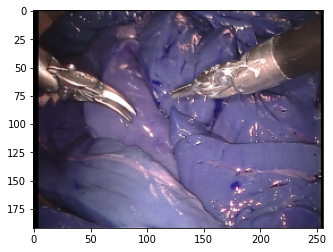

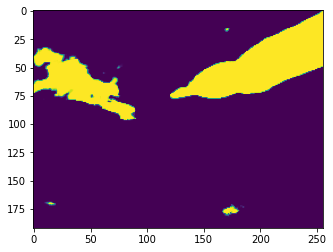

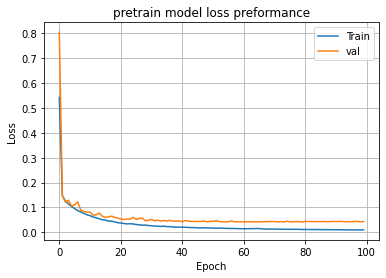

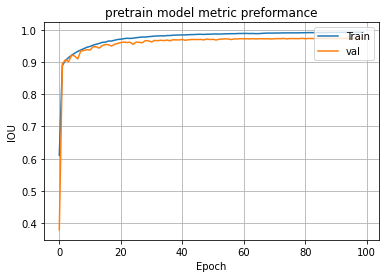

In [23]:
import pandas as pd

plt.imshow(rawTesting[500])
plt.show()
plt.imshow(pred[500])
plt.show()

logs = pd.read_csv('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/trainingprestage.csv')



# # Plot training & validation loss values
plt.figure()
plt.plot(logs['loss'])
plt.plot(logs['val_loss'])
plt.title('pretrain model loss preformance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper right')
plt.grid('on')
plt.show()

# plot IOU valid and training 
plt.figure()
plt.plot(logs['IoU'])
plt.plot(logs['val_IoU'])
plt.title('pretrain model metric preformance')
plt.ylabel('IOU')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper right')
plt.grid('on')
plt.show()

In [7]:
#Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_total','val_total'], loc='upper right')
plt.grid('on')
plt.show()



NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>